# Connected and Autonomous Driving - Control module

----

In this module, we will learn how to control an autonomous vehicle to follow a specific path defined by a serie of waypoints. Our goal is to emulate the input command that would normally be provided by a human user: torque, brake and steering.

In this notebook, you will get to implement the PID controller covered in class, then use your code directly inside the CARLA Simulation.

## Introduction to scientific computing in Python

The practical sessions of this class assume some basic familiarity with Python, Jupyter Notebooks, and the NumPy ecosystem.

For an excellent introduction to these concepts, see [the following introductory notebook from Stanford University](https://drive.google.com/file/d/1iQ6yZ3R_SaMCbAUUkwarOk-iFPywQ4-7/view?usp=sharing).

Do not hesitate to create additional code and markdown cells to answer the questions in this notebook.

In [ ]:
# this package allow you to use the sliders in the following graphs
# pip install ipympl

In [ ]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider

In [ ]:
%matplotlib widget

## Longitudinal controller

Before handling directions, let's start by making our car follow a target speed by going in a straigth line.

### Let's start with a simple P controller

The Proportional (P) controller try to reduce the difference between the target speed and the current speed: $error(t) = v_{target} - v(t)$.

To do so, it provide a throttle value that is proportional to that error, with a factor called proportional gain $K_p$:

$$throttle = K_p * error(t)$$

Fill the code below in update() to calculate the error value as well as the output throttle


In [ ]:
 
# Define PID Controller class with resistance
class ProportionalControllerWithResistance:
    def __init__(self, Kp, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.target_speed = target_speed
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
 
    def update(self, current_value, dt):
        error = self.target_speed - current_value
        output = self.Kp  * error

        return output - self.resistance_factor * current_value # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target

Now, let's do a simple simulation over 50 seconds to see how your controller behave
- Does it reach the target speed ?
- What happens when you change $K_p$ ? The resistance ? Do not hesitate to change the bound of the slider for higher or lower values (look at the parameters of Kp_slider).

In [ ]:
# Simulation parameters
dt = 0.01  # Time step
duration = 50
time = np.arange(0, duration, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = duration*0.6  # Time to change vehicle target speed
default_Kp = 0.1
 
 
# Simulate the system with resistance
def f(Kp):
    # Initialize the PID controller with disturbance (resistance)
    pid_with_resistance = ProportionalControllerWithResistance(Kp=Kp, target_speed=target_speed1, resistance_factor=0.01)
     
     # Initial conditions
    speed = 0
    throttle_with_resistance = []
    speed_record_with_resistance = []  # Our focus is on controlling the speed, but you can also display the throttle over time by changing the return value

    for t in time:
        control = pid_with_resistance.update(speed, dt)
        speed += control * dt  # Speed is affected by throttle control and resistance
        throttle_with_resistance.append(control)
        speed_record_with_resistance.append(speed)
        if t==switch_t:
            pid_with_resistance.set_target(target_speed2)
    
    return speed_record_with_resistance
 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.2, right=1,bottom=0.3)
 
l, = ax.plot(time, f(default_Kp), label="Speed Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Target speed 1', xmax=switch_t/duration)
plt.axhline(target_speed2, color='g', linestyle='--', label='Target speed 2', xmin=switch_t/duration)
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Longitudinal Proportional controller with Resistance')
plt.legend()


# Make a vertically oriented slider to control the Gain
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
Kp_slider = Slider(
    ax=axamp,
    label="Kp",
    valmin=0,
    valmax=5,
    valinit=default_Kp,
    orientation="vertical"
)
def update(val):
    l.set_ydata(f(Kp_slider.val))
    fig.canvas.draw_idle()

Kp_slider.on_changed(update)

plt.show()


### Adding a derivative to anticipate the future

To get closer to the target, we improve our controler as a proportional derivative (PD). 

$$throttle(t) = K_p * error(t) + K_d * \frac{error(t)-error(t-1)}{\Delta t} $$

Include this new version in the update() method.

In [ ]:
class PDControllerWithResistance:
    def __init__(self, Kp, Kd, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.Kd = Kd
        self.target_speed = target_speed
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
        self.error_prev = 0
        self.first = True

    def update(self, current_value, dt):
        error = self.target_speed - current_value

        if self.first:
            self.error_prev = error
        self.first = False

        
        der = (error - self.error_prev)/dt
        output = self.Kp  * error + self.Kd * der

        self.error_prev = error
        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 

Let's simulate again.

- Is it reaching the target better than before ?
- Did the derivative component improve the controller ? Why ?
- What new issue did the PD introduce ?
- what happens when you change $K_p$ and $K_i$ ?

In [ ]:
# Simulation parameters
dt = 0.1  # Time step
duration = 50
time = np.arange(0, duration, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = 50  # Time to change vehicle target speed
max_throttle = 40
max_brake = 200
 
# Initialize the PID controller with disturbance (resistance)
pid_with_resistance = PDControllerWithResistance(Kp=1, Kd=0.1, target_speed=target_speed1, resistance_factor=0.4)
 
# Initial conditions
speed = 0
throttle_with_resistance = []
speed_record_with_resistance = []
 
# Simulate the system with resistance
for t in time:
    control = pid_with_resistance.update(speed, dt)
    control = min(control, max_throttle)
    control = max(control, (-1)*max_brake)
    speed += control * dt  # Speed is affected by throttle control and resistance
    throttle_with_resistance.append(control)
    speed_record_with_resistance.append(speed)
    if t==switch_t:
        pid_with_resistance.set_target(target_speed2)
 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.3)
 
l, = plt.plot(time, speed_record_with_resistance, label="Velocity Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Set Point 1', xmax=switch_t/duration)
plt.axhline(target_speed2, color='r', linestyle='--', label='Set Point 2', xmin=switch_t/duration)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('PD Cruise Control with Resistance')
plt.legend()
plt.show()

### Finishing the PID

Finally, the Proportional Integral Derivative (PID) controller adds a term to accumulate past errors:

$$throttle(t) = K_p * error(t) + K_i * \sum_{n=0} ^t error(n)\Delta t + K_d * \frac{error(t)-error(t-1)}{\Delta t} $$

In [ ]:
class PIDControllerWithResistance:
    def __init__(self, Kp, Ki, Kd, target_speed=0, resistance_factor=0.1):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.target_speed = target_speed
        self.resistance_factor = resistance_factor  # Resistance to throttle (e.g., air resistance, friction)
        self.errors = []

    def update(self, current_value, dt):
        error = self.target_speed - current_value
        self.errors.append(error)
        
        der = (error - self.errors[-1])/dt
        output = self.Kp * error + self.Ki*sum(self.errors)*dt + self.Kd * der

        return output - self.resistance_factor * current_value  # Reduce output by a resistance factor
    
    def set_target(self, target):
        self.target_speed = target
 

Let's simulate again

- Is it reaching the target better than before ?
- Did the integral component improve the controller ? Why ?
- what happens when you change $K_p$, $K_i$ and $K_d$ ?

In [ ]:
# Simulation parameters
dt = 0.1  # Time step
duration = 50
time = np.arange(0, duration, dt)  # Simulation time
target_speed1 = 50  # Target speeds
target_speed2 = 30
switch_t = duration*0.6  # Time to change vehicle target speed
max_throttle = 40
max_brake = 200

default_Kp = 1
default_Ki = 0.2
default_Kd = 0.5

 
# Simulate the system with resistance
def f(Kp, Ki, Kd):
    # Initialize the PID controller with disturbance (resistance)
    pid_with_resistance = PIDControllerWithResistance(Kp=Kp, Ki=Ki, Kd=Kd, target_speed=target_speed1, resistance_factor=0.1)     

     # Initial conditions
    speed = 0
    speed_record_with_resistance = []
    throttle_with_resistance = []

 
    # Simulate the system with resistance
    for t in time:
        control = pid_with_resistance.update(speed, dt)
        control = min(control, max_throttle)
        control = max(control, (-1)*max_brake)
        speed += control * dt  # Speed is affected by throttle control and resistance
        speed_record_with_resistance.append(speed)
        throttle_with_resistance.append(control)
        if t==switch_t:
            pid_with_resistance.set_target(target_speed2)
    return speed_record_with_resistance

 
# Plot setup
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.3)
 
l, = ax.plot(time, f(default_Kp, default_Ki, default_Kd), label="Velocity Output (With Resistance)")
plt.axhline(target_speed1, color='r', linestyle='--', label='Target 1', xmax=switch_t/duration)
plt.axhline(target_speed2, color='r', linestyle='--', label='Target 2', xmin=switch_t/duration)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('PID Cruise Control with Resistance')
plt.legend()


# Make a vertically oriented slider to control the Gains
pxamp = fig.add_axes([0.05, 0.25, 0.0225, 0.63])
Kp_slider = Slider(
    ax=pxamp,
    label="Kp",
    valmin=0,
    valmax=2,
    valinit=default_Kp,
    orientation="vertical"
)

ixamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
Ki_slider = Slider(
    ax=ixamp,
    label="Ki",
    valmin=0,
    valmax=2,
    valinit=default_Ki,
    orientation="vertical"
)

dxamp = fig.add_axes([0.15, 0.25, 0.0225, 0.63])
Kd_slider = Slider(
    ax=dxamp,
    label="Kd",
    valmin=0,
    valmax=2,
    valinit=default_Kd,
    orientation="vertical"
)

def update(val):
    l.set_ydata(f(Kp_slider.val, Ki_slider.val, Kd_slider.val))
    fig.canvas.draw_idle()

Kp_slider.on_changed(update)
Ki_slider.on_changed(update)
Kd_slider.on_changed(update)

plt.show()


 You have now successfully built a longitudinal PID controller! Now, we will add a lateral PID controll as well in order to control the direction of our vehicle.

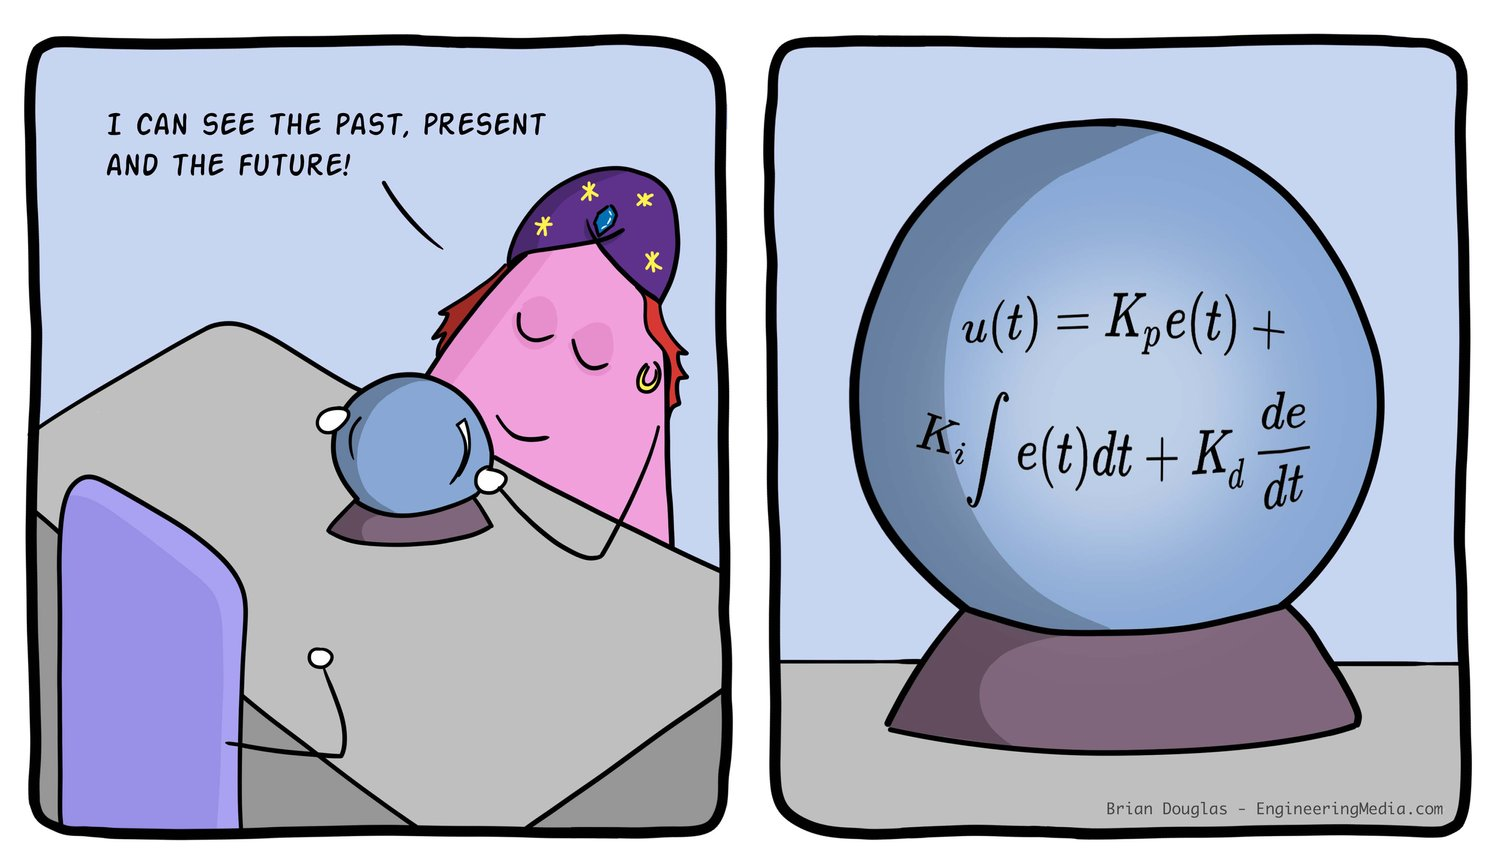

# Lateral PID
You may be able to control the speed of your vehicle, but your current PID will not allow you to follow a given path. For that, you will need a lateral PID as well that will force your vehicle to remain aligned with the road.

## You will implement the lateral PID directly in CARLA
You can move to the "control.py" file to finalize the PID controller and start by implementing your longitudinal PID from before.

For this new PID, the controller will be roughly the same. However, instead of applying it to speed error, you will apply it to the error between the vehicle speed vector $v_{vec}$ and the path vector of the waypoints $w_{vec}$ :

$$\dot{\theta} = \arccos{\frac{v_{vec} \cdot w_{vec}}{||v_{vec}|| \times ||w_{vec}||}}$$

The error angle $\dot{\theta}$ gives you the magnitude of the error, but it is not sufficient for this PID as you also need to know its sign in order to turn in the right direction. For this, we use the cross product of the 2 vectors whose vertical component will be positive when the error is toward the right, or negative when it is toward the left.

$cross = v_{vec} \times w_{vec}$  

$cross < 0 \implies \dot{\theta} \times -1$

Using this new error, you can apply the same math as you did with the longitudinal PID.

tips: you can use the np.dot() function to calculate the dot product of 2 vectors, and np.cross() for the cross product.

## CARLA evaluation scenarios

Use the Simulation_control.py script with the argument '--scenario x' to run the different experiments. For every task, provide the PID parameters used and explain what happens with your vehicle. You may change the PID parameters in the local_planner.py file, by modifying *_args_lateral_dict* and *_args_longitudinal_dict*. Consider putting Kd or Ki to 0 to simulate a PI or PD controller.
- x=1: The vehicle is accelerating in a long straight line. 
Modify the PID parameters to: 
    - get the smoothest acceleration possible.
    - get the vehicle to largely overshoot.
    - get the vehicle speed to oscillate.
- x=2: The vehicle is accelerating in a large turn, then maintaining constant speed in a straight line and another turn. 
Modify the PID parameters to:
    - get the smoothest acceleration and trajectory possible in the turns.
    - get the vehicle trajectory to oscillate. 

Now modify the speed limit: try to go as fast as possible while maintaining a good trajectory !
You can specify the speed target of your vehicle with the argument --speed. The default value is 30 km/h.

If you want to test your vehicle, use the --loop argument to let your vehicle continue to explore random destinations on the map.

## Questions

- How do you calculate the target direction ? The error ?
- In the CARLA implementation of the lateral PID:
    - Which variable represent the speed vector and the target vector ? How are they calculated ?
    - What does the variable 'wv_linalg' correspond to ?
- Comment the results of tuning your PID parameters in the previous scenarios. Specify the parameters you chose to keep for the lateral and longitudinal PID.